In [1]:
# Check the GPU
!nvidia-smi -L

# # Mount Google Drive
# from google.colab import drive
# drive.mount('drive', force_remount=True)

# Install Tacotron2 (w/ARPAbet)
%matplotlib inline
import os
import io

%cd /content/
if not os.path.isdir("/content/TTS-TT2/"):
  print("Cloning justinjohn0306/TTS-TT2")
  !git clone https://github.com/justinjohn0306/ARPAtaco2.git TTS-TT2
  %cd /content/TTS-TT2/
  !git submodule init
  !git submodule update

%cd /content/TTS-TT2/
print("Downloading tacotron2 requirements")
!pip install matplotlib numpy inflect scipy Unidecode pillow
!pip install git+https://github.com/wkentaro/gdown.git
import gdown
!git submodule init
!git submodule update
!pip install ffmpeg-normalize
!pip install -q unidecode tensorboardX
!apt-get -qq install sox
!apt-get install pv
!apt-get install jq
!wget https://raw.githubusercontent.com/tonikelope/megadown/master/megadown -O megadown.sh
!chmod 755 megadown.sh

# Download NVIDIA's LJSpeech model using wget
tt2_pretrained_url = "https://github.com/justinjohn0306/ARPAtaco2/releases/download/pretrained_model/tacotron2_statedict.pt"
tt2_pretrained_path = "/content/TTS-TT2/tacotron2_statedict.pt"
if not os.path.isfile(tt2_pretrained_path):
  print("Downloading tt2 pretrained model using wget")
  !wget {tt2_pretrained_url} -O {tt2_pretrained_path}


GPU 0: Tesla T4 (UUID: GPU-8c696d06-e7a8-02fd-ff41-af90f3f97bf2)
/content
Cloning justinjohn0306/TTS-TT2
Cloning into 'TTS-TT2'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 89 (delta 2), reused 1 (delta 0), pack-reused 80
Receiving objects: 100% (89/89), 7.11 MiB | 7.23 MiB/s, done.
Resolving deltas: 100% (30/30), done.
/content/TTS-TT2
/content/TTS-TT2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.7 MB/s eta 0:00:00
  Cloning https://github.com/wkentaro/gdown.git to /tmp/pip-req-build-vzc38v8c
  Running command git clone --filter=blob:none --quiet https://github.com/wkentaro/gdown.git /tmp/pip-req-build-vzc38v8c
  Resolved https://github.com/wkentaro/gdown.git to commit eeb6995f2e077991576b35956983bbefe34cf057
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gdown

In [2]:
# Load dataset
audio_processing = True

from google.colab import files
import zipfile
import os
import wave
import shutil
import datetime

# Ensure the wavs directory exists
os.makedirs('/content/TTS-TT2/wavs/', exist_ok=True)

if os.listdir('/content/TTS-TT2/wavs/'):
  !rm -r /content/TTS-TT2/wavs/*

# Upload the zip file
print("Upload your dataset(audios)...")
uploaded = files.upload()

for fn in uploaded.keys():
  if zipfile.is_zipfile(fn):
    with zipfile.ZipFile(fn, 'r') as zip_ref:
      zip_ref.extractall('/content/TTS-TT2/wavs')
    !rm "$fn"

totalduration = 0
wav_count = 0
for file_name in os.listdir('/content/TTS-TT2/wavs'):
    if file_name.endswith('.wav'):
        file_path = os.path.join('/content/TTS-TT2/wavs', file_name)
        with wave.open(file_path, "rb") as wave_file:
            frames = wave_file.getnframes()
            rate = wave_file.getframerate()
            duration = frames / float(rate)
            totalduration += duration
            if duration >= 12:
                print(f"\n\033[33m\033[1m[NOTICE] {file_name} is longer than 12 seconds. Lack of RAM can occur in a large batch size!")
            wav_count += 1

print(f"\n{wav_count} processed audios. total duration: {str(datetime.timedelta(seconds=round(totalduration, 0)))}\n")


Upload your dataset(audios)...


Saving wavs.zip to wavs.zip

100 processed audios. total duration: 0:10:47



In [3]:
# Upload the transcript
from google.colab import files
import os

%cd /content/TTS-TT2/filelists/
!rm -f /content/TTS-TT2/filelists/list.txt

print("\nUpload your transcript(list)...")
uploaded = files.upload()

for filename in uploaded.keys():
    if filename != "list.txt":
        os.rename(filename, "list.txt")

# Verify the contents of the uploaded list.txt
with open('list.txt', 'r') as file:
    lines = file.readlines()
    print(f"Number of lines in list.txt: {len(lines)}")
    if len(lines) > 0:
        print(f"First line of list.txt: {lines[0]}")
    else:
        print("list.txt is empty.")

%cd /content/TTS-TT2/
print("All set, please proceed.")


/content/TTS-TT2/filelists

Upload your transcript(list)...


Saving list.txt to list.txt
Number of lines in list.txt: 100
First line of list.txt: /content/TTS-TT2/wavs/1.wav|E WORST WHICH PERHAPS WAS THE ENGLISH WAS A TERRIBLE FALLING OFF FROM THE WORK OF THE EARLIER PRESSES

/content/TTS-TT2
All set, please proceed.


In [8]:
# Configure the model parameters
import torch
from hparams import create_hparams

warm_start = False
n_gpus = 1
rank = 0
group_name = None

# ---- DEFAULT PARAMETERS DEFINED HERE ----
hparams = create_hparams()
model_filename = 'current_model'
hparams.training_files = "filelists/list.txt"
hparams.validation_files = "filelists/list.txt"
hparams.p_attention_dropout = 0.1
hparams.p_decoder_dropout = 0.1
hparams.decay_start = 15000
hparams.A_ = 5e-4
hparams.B_ = 8000
hparams.C_ = 0
hparams.min_learning_rate = 1e-3 #["3e-6", "1e-5", "1e-4", "5e-4", "1e-3"]
generate_mels = True
hparams.show_alignments = True
alignment_graph_height = 600
alignment_graph_width = 1000
hparams.batch_size = 3
hparams.load_mel_from_disk = True
hparams.ignore_layers = []
hparams.epochs = 1
torch.backends.cudnn.enabled = hparams.cudnn_enabled
torch.backends.cudnn.benchmark = hparams.cudnn_benchmark
output_directory = '/content' # Location to save Checkpoints
log_directory = '/content/TTS-TT2/logs' # Location to save Log files locally
log_directory2 = '/content/drive/My Drive/colab/logs' # Location to copy log files (done at the end of each epoch to cut down on I/O)
checkpoint_path = '/content/TTS-TT2/tacotron2_statedict.pt'

# Replace .wav with .npy in filelists
!sed -i -- 's,.wav|,.npy|,g' filelists/*.txt
!sed -i -- 's,.wav|,.npy|,g' {hparams.training_files}
!sed -i -- 's,.wav|,.npy|,g' {hparams.validation_files}

%cd /content/TTS-TT2
data_path = 'wavs'
!mkdir {data_path}


/content/TTS-TT2
mkdir: cannot create directory ‘wavs’: File exists


In [ ]:
from utils import load_wav_to_torch, load_filepaths_and_text
import layers
import glob
import numpy as np
import torch.autograd
from tqdm.notebook import tqdm

def create_mels():
    print("Generating Mels")
    stft = layers.TacotronSTFT(
                hparams.filter_length, hparams.hop_length, hparams.win_length,
                hparams.n_mel_channels, hparams.sampling_rate, hparams.mel_fmin,
                hparams.mel_fmax)
    def save_mel(filename):
        audio, sampling_rate = load_wav_to_torch(filename)
        if sampling_rate != stft.sampling_rate:
            raise ValueError("{} {} SR doesn't match target {} SR".format(filename,
                sampling_rate, stft.sampling_rate))
        audio_norm = audio / hparams.max_wav_value
        audio_norm = audio_norm.unsqueeze(0)
        audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
        melspec = stft.mel_spectrogram(audio_norm)
        melspec = torch.squeeze(melspec, 0).cpu().numpy()
        np.save(filename.replace('.wav', ''), melspec)

    wavs = glob.glob('wavs/*.wav')
    for i in tqdm(wavs):
        save_mel(i)

if generate_mels:
    create_mels()

print("Checking for missing files")
!sed -i -- 's,.wav|,.npy|,g' {hparams.training_files}; sed -i -- 's,.wav|,.npy|,g' {hparams.validation_files}

def check_dataset(hparams):
    def check_arr(filelist_arr):
        for i, file in enumerate(filelist_arr):
            if len(file) > 2:
                print("|".join(file), "\nhas multiple '|', this may not be an error.")
            if hparams.load_mel_from_disk and '.wav' in file[0]:
                print("[WARNING]", file[0], " in filelist while expecting .npy .")
            else:
                if not hparams.load_mel_from_disk and '.npy' in file[0]:
                    print("[WARNING]", file[0], " in filelist while expecting .wav .")
            if (not os.path.exists(file[0])):
                print("|".join(file), "\n[WARNING] does not exist.")
            if len(file[1]) < 3:
                print("|".join(file), "\n[info] has no/very little text.")
            if not ((file[1].strip())[-1] in r"!?,.;:"):
                print("|".join(file), "\n[info] has no ending punctuation.")
            mel_length = 1
            if hparams.load_mel_from_disk and '.npy' in file[0]:
                melspec = torch.from_numpy(np.load(file[0], allow_pickle=True))
                mel_length = melspec.shape[1]
            if mel_length == 0:
                print("|".join(file), "\n[WARNING] has 0 duration.")
    print("Checking Training Files")
    audiopaths_and_text = load_filepaths_and_text(hparams.training_files)
    check_arr(audiopaths_and_text)
    print("Checking Validation Files")
    audiopaths_and_text = load_filepaths_and_text(hparams.validation_files)
    check_arr(audiopaths_and_text)
    print("Finished Checking")

check_dataset(hparams)


In [6]:
%cd /content/TTS-TT2/
import text
print(text.sequence_to_text(text.text_to_sequence("We must capture an Earth creature, K 9, and return it back with us to Mars.", ["cmudict_cleaners", "english_cleaners"])))


/content/TTS-TT2
{W IY1} {M AH1 S T} {K AE1 P CH ER0} {AE1 N} {ER1 TH} {K R IY1 CH ER0} , {K EY1} nine , {AH0 N D} {R IH0 T ER1 N} {IH1 T} {B AE1 K} {W IH1 DH} {AH1 S} {T UW1} {M AA1 R Z} .


FP16 Run: False
Dynamic Loss Scaling: True
Distributed Run: False
cuDNN Enabled: True
cuDNN Benchmark: False
Training dataset size: 100 samples
Validation dataset size: 100 samples
Loading checkpoint '/content/TTS-TT2/tacotron2_statedict.pt'
Loaded checkpoint '/content/TTS-TT2/tacotron2_statedict.pt' from iteration 34


  0%|          | 0/18 [00:00<?, ?it/s]


Starting Epoch: 2 Iteration: 35


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 2 Validation loss 51:  0.329576  Time: 0.9m LR: 0.000500


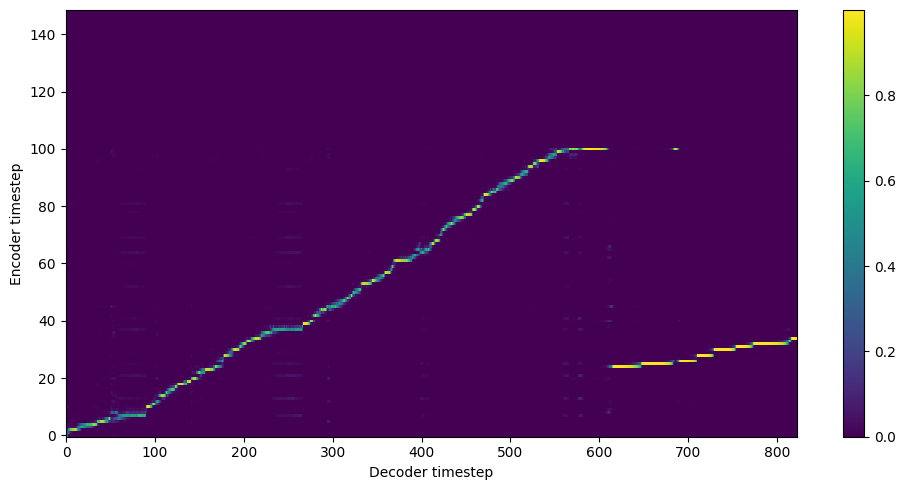


Starting Epoch: 3 Iteration: 51


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 3 Validation loss 67:  0.315148  Time: 0.9m LR: 0.000500


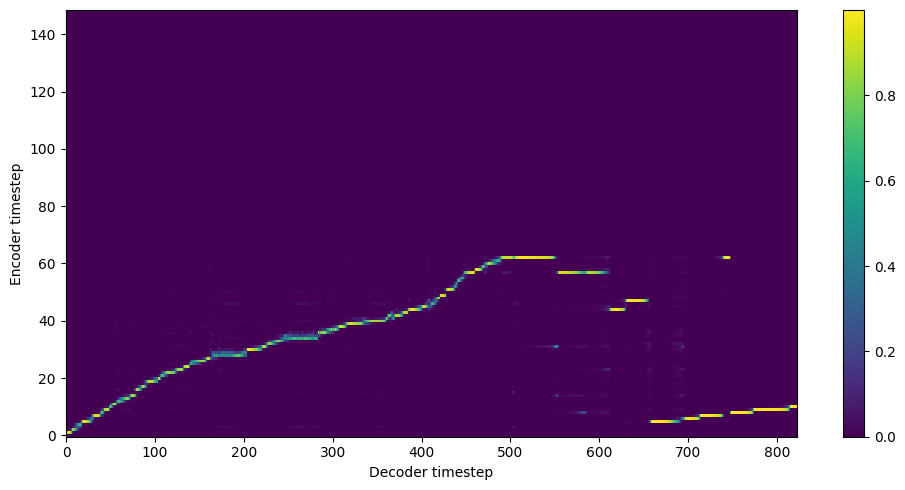


Starting Epoch: 4 Iteration: 67


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 4 Validation loss 83:  0.308986  Time: 0.9m LR: 0.000500


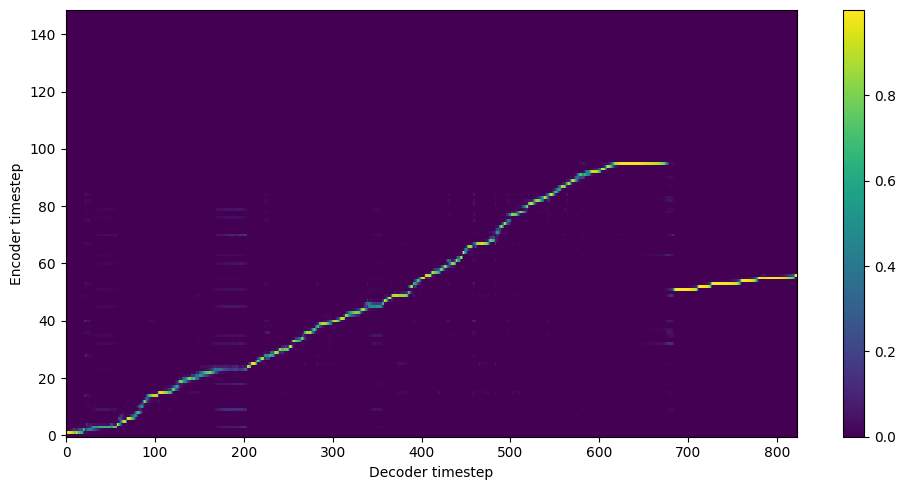


Starting Epoch: 5 Iteration: 83


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 5 Validation loss 99:  0.315130  Time: 0.9m LR: 0.000500


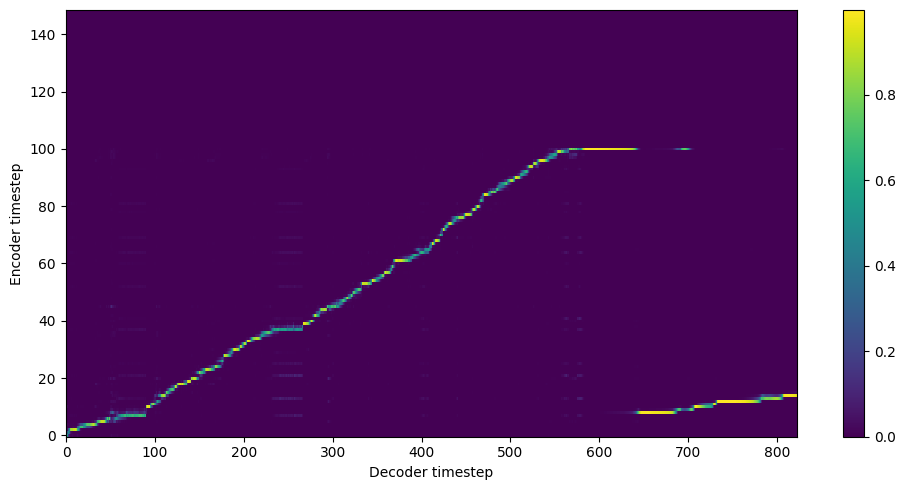


Starting Epoch: 6 Iteration: 99


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 6 Validation loss 115:  0.295600  Time: 0.9m LR: 0.000500


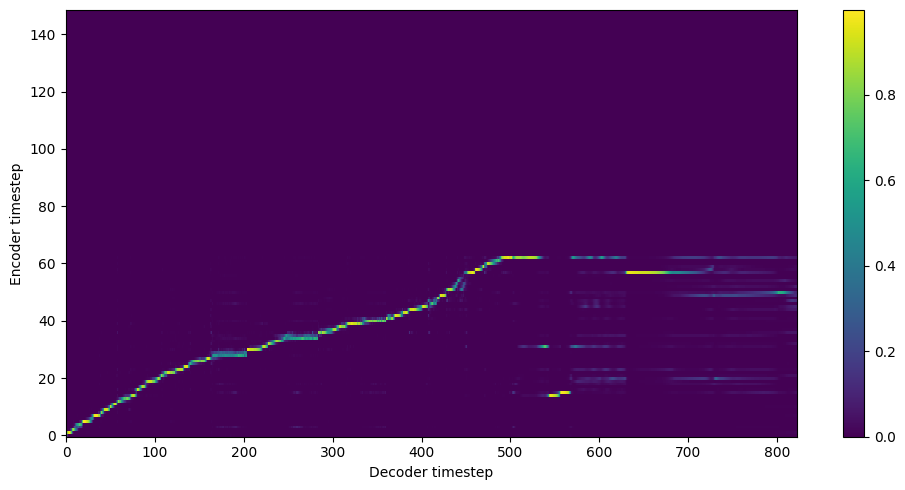


Starting Epoch: 7 Iteration: 115


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 7 Validation loss 131:  0.280592  Time: 0.9m LR: 0.000500


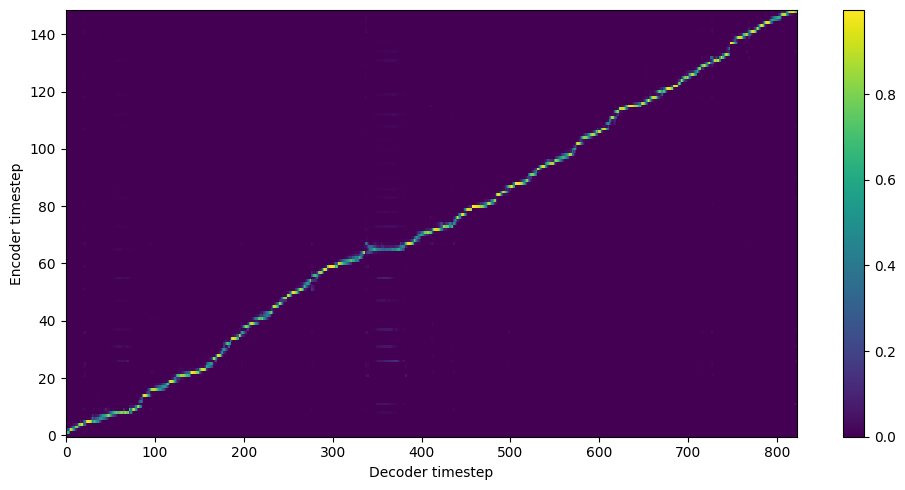


Starting Epoch: 8 Iteration: 131


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 8 Validation loss 147:  0.283252  Time: 0.9m LR: 0.000500


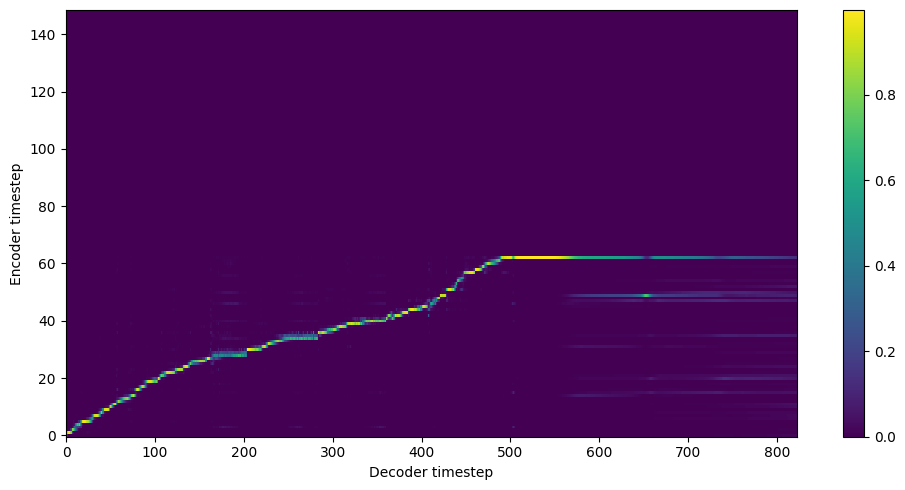


Starting Epoch: 9 Iteration: 147


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 9 Validation loss 163:  0.281288  Time: 0.9m LR: 0.000500


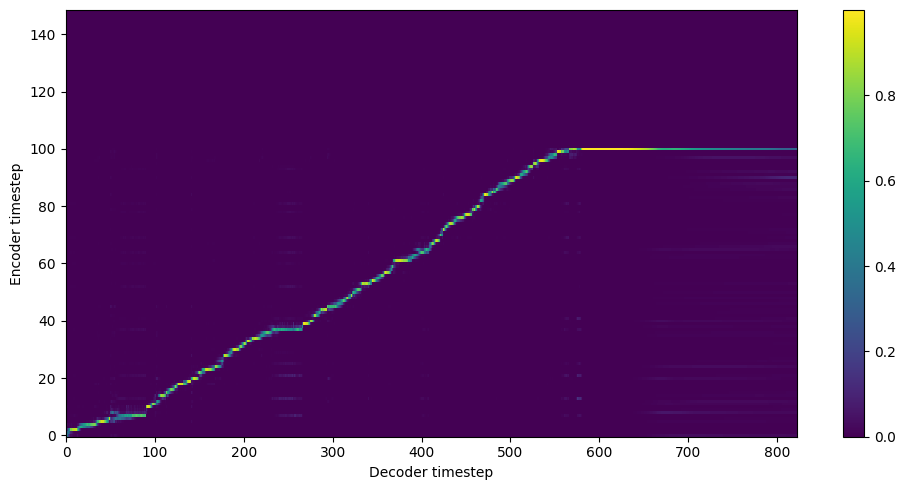

Saving model and optimizer state at iteration 163 to /content/checkpoint_epoch_10.pt
Model Saved

Starting Epoch: 10 Iteration: 163


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 10 Validation loss 179:  0.272366  Time: 0.9m LR: 0.000500


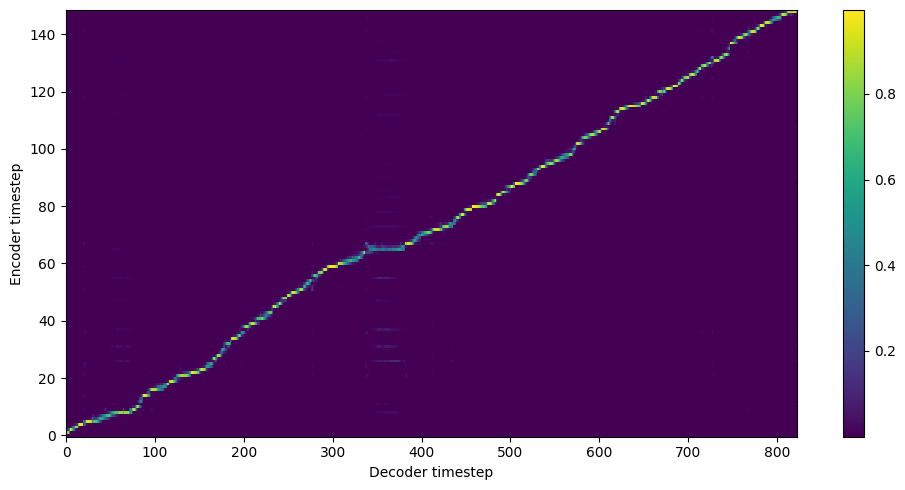


Starting Epoch: 11 Iteration: 179


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 11 Validation loss 195:  0.260628  Time: 0.9m LR: 0.000500


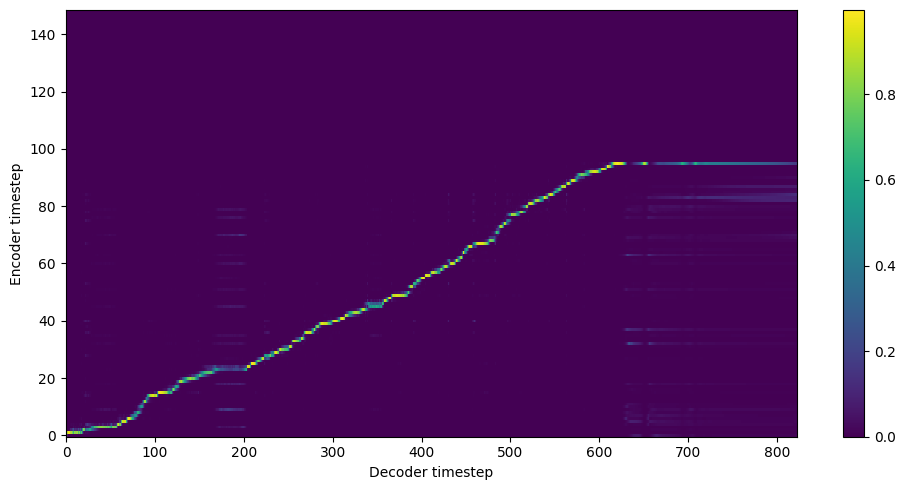


Starting Epoch: 12 Iteration: 195


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 12 Validation loss 211:  0.260013  Time: 0.9m LR: 0.000500


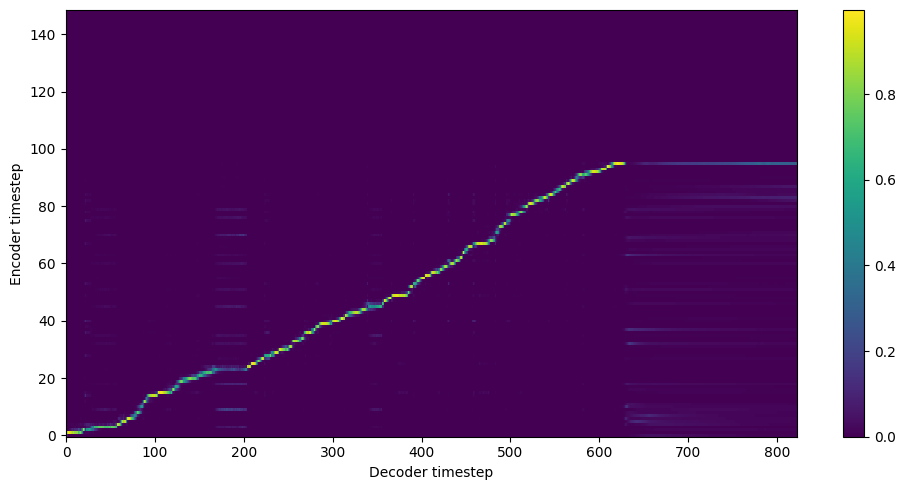


Starting Epoch: 13 Iteration: 211


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 13 Validation loss 227:  0.252031  Time: 0.9m LR: 0.000500


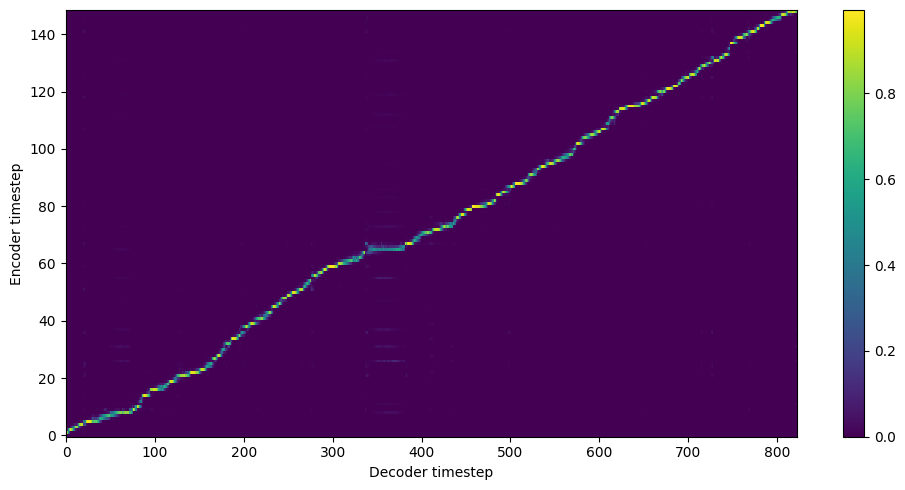


Starting Epoch: 14 Iteration: 227


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 14 Validation loss 243:  0.249051  Time: 0.9m LR: 0.000500


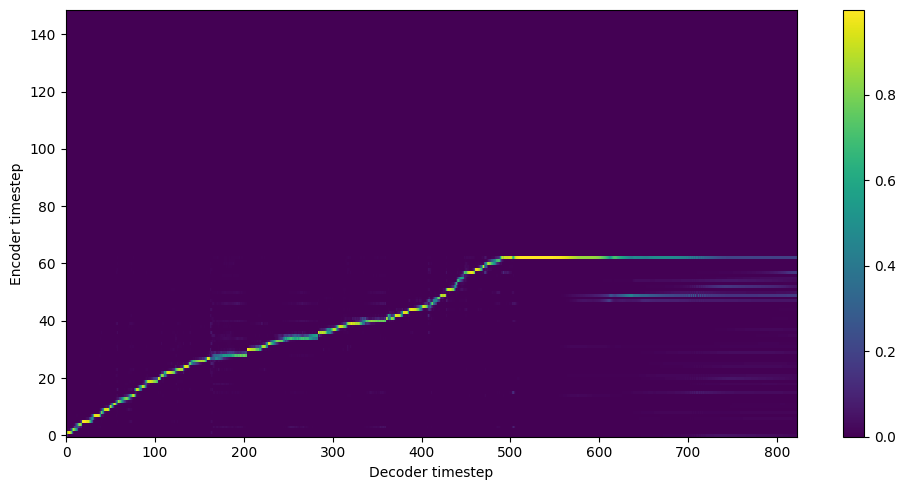


Starting Epoch: 15 Iteration: 243


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 15 Validation loss 259:  0.245900  Time: 0.9m LR: 0.000500


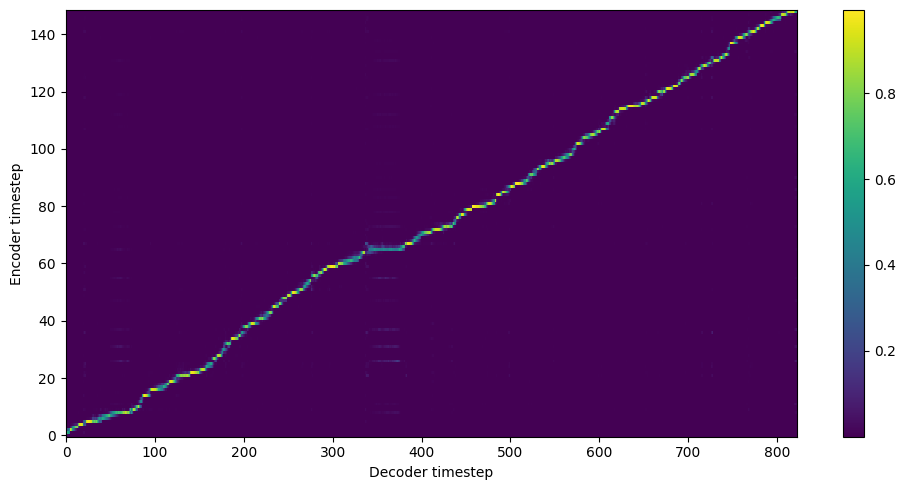


Starting Epoch: 16 Iteration: 259


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 16 Validation loss 275:  0.243715  Time: 0.9m LR: 0.000500


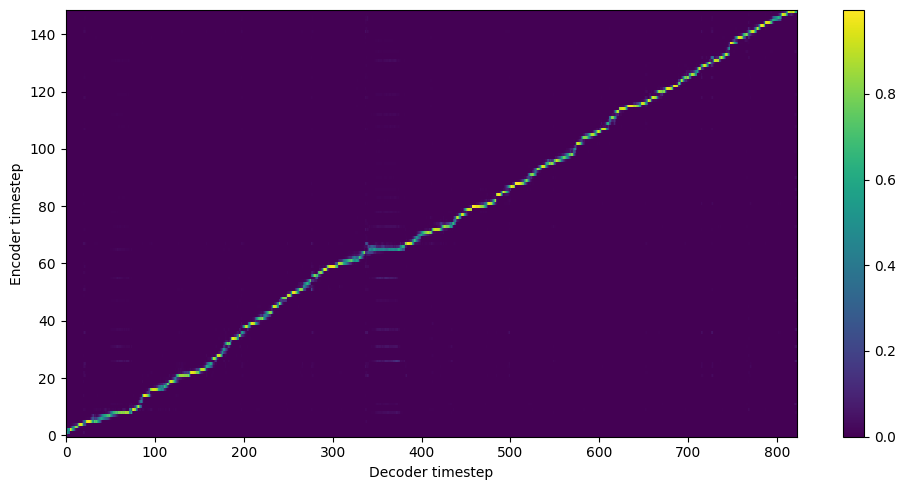


Starting Epoch: 17 Iteration: 275


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 17 Validation loss 291:  0.235171  Time: 0.9m LR: 0.000500


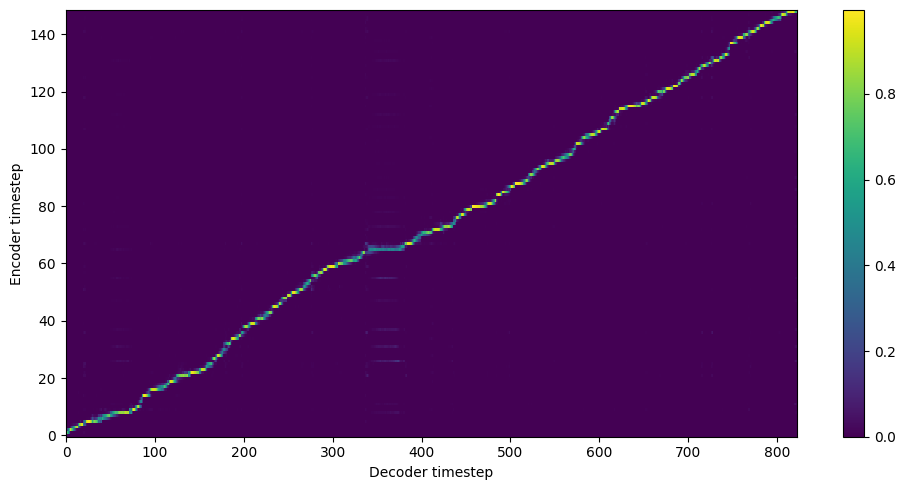


Starting Epoch: 18 Iteration: 291


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 18 Validation loss 307:  0.234952  Time: 0.9m LR: 0.000500


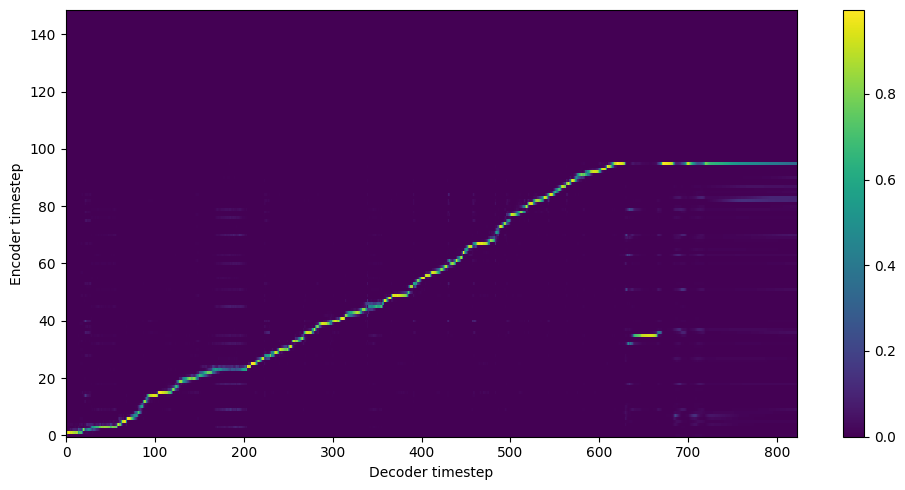


Starting Epoch: 19 Iteration: 307


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 19 Validation loss 323:  0.226553  Time: 0.9m LR: 0.000500


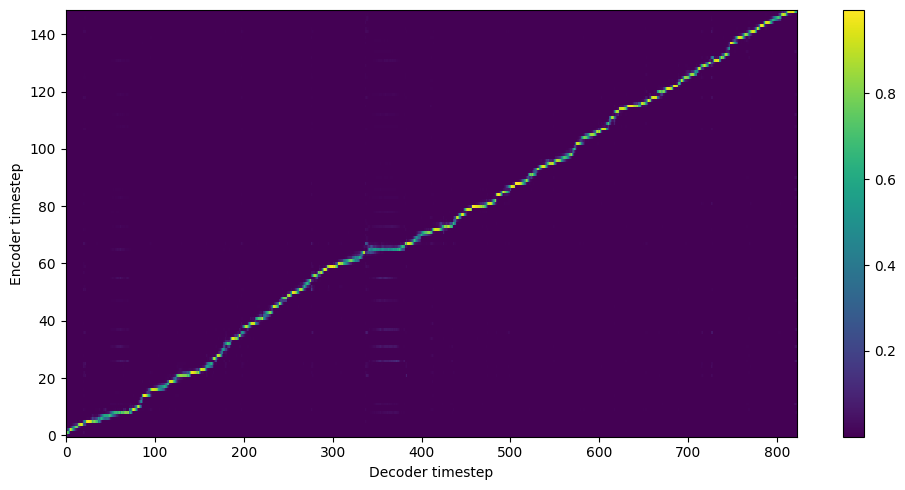

Saving model and optimizer state at iteration 323 to /content/checkpoint_epoch_20.pt
Model Saved


In [11]:
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from distutils.dir_util import copy_tree

from model import Tacotron2
from data_utils import TextMelLoader, TextMelCollate
from loss_function import Tacotron2Loss
from logger import Tacotron2Logger
from distributed import apply_gradient_allreduce
import torch.distributed as dist
from torch.utils.data import DataLoader
from torch.utils.data.distributed import DistributedSampler
import os

def load_model(hparams):
    model = Tacotron2(hparams).cuda()
    if hparams.fp16_run:
        model.decoder.attention_layer.score_mask_value = finfo('float16').min

    if hparams.distributed_run:
        model = apply_gradient_allreduce(model)

    return model

def warm_start_model(checkpoint_path, model, ignore_layers):
    if os.path.isfile(checkpoint_path):
        print("Warm starting model from checkpoint '{}'".format(checkpoint_path))
        checkpoint_dict = torch.load(checkpoint_path, map_location='cpu')
        model_dict = checkpoint_dict['state_dict']
        if len(ignore_layers) > 0:
            model_dict = {k: v for k, v in model_dict.items() if k not in ignore_layers}
            dummy_dict = model.state_dict()
            dummy_dict.update(model_dict)
            model_dict = dummy_dict
        model.load_state_dict(model_dict)
    else:
        print("Checkpoint not found, starting training from scratch.")
    return model

def load_checkpoint(checkpoint_path, model, optimizer):
    assert os.path.isfile(checkpoint_path), f"Checkpoint not found at {checkpoint_path}"
    print(f"Loading checkpoint '{checkpoint_path}'")
    checkpoint_dict = torch.load(checkpoint_path, map_location='cpu')

    model.load_state_dict(checkpoint_dict['state_dict'])

    if 'optimizer' in checkpoint_dict:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
        learning_rate = checkpoint_dict['learning_rate']
        iteration = checkpoint_dict['iteration']
        print(f"Loaded checkpoint '{checkpoint_path}' from iteration {iteration}")
    else:
        print("Optimizer state not found in checkpoint. Starting from scratch for optimizer.")
        learning_rate = hparams.learning_rate
        iteration = 0

    return model, optimizer, learning_rate, iteration

def save_checkpoint(model, optimizer, learning_rate, iteration, filepath):
    print("Saving model and optimizer state at iteration {} to {}".format(iteration, filepath))
    try:
        torch.save({'iteration': iteration,
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'learning_rate': learning_rate}, filepath)
    except KeyboardInterrupt:
        print("Interrupt received while saving, waiting for save to complete.")
        torch.save({'iteration': iteration,
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'learning_rate': learning_rate}, filepath)
    print("Model Saved")

def validate(model, criterion, valset, iteration, batch_size, n_gpus,
             collate_fn, logger, distributed_run, rank, epoch, start_eposh, learning_rate):
    model.eval()
    with torch.no_grad():
        val_sampler = DistributedSampler(valset) if distributed_run else None
        val_loader = DataLoader(valset, sampler=val_sampler, num_workers=1,
                                shuffle=False, batch_size=batch_size,
                                pin_memory=False, collate_fn=collate_fn)

        val_loss = 0.0
        for i, batch in enumerate(val_loader):
            x, y = model.parse_batch(batch)
            x = [item.cuda() if isinstance(item, torch.Tensor) else item for item in x]
            y = [item.cuda() if isinstance(item, torch.Tensor) else item for item in y]
            y_pred = model(x)
            loss = criterion(y_pred, y)
            if distributed_run:
                reduced_val_loss = reduce_tensor(loss.data, n_gpus).item()
            else:
                reduced_val_loss = loss.item()
            val_loss += reduced_val_loss
        val_loss = val_loss / (i + 1)

    model.train()
    if rank == 0:
        print("Epoch: {} Validation loss {}: {:9f}  Time: {:.1f}m LR: {:.6f}".format(epoch, iteration, val_loss, (time.perf_counter() - start_eposh) / 60, learning_rate))
        logger.log_validation(val_loss, model, y, y_pred, iteration)
        if hparams.show_alignments:
            %matplotlib inline
            _, mel_outputs, gate_outputs, alignments = y_pred
            idx = random.randint(0, alignments.size(0) - 1)
            plot_alignment(alignments[idx].data.cpu().numpy().T)

def plot_alignment(alignment, info=None):
    fig, ax = plt.subplots(figsize=(10, 5))
    im = ax.imshow(alignment, aspect='auto', origin='lower', interpolation='none')
    fig.colorbar(im, ax=ax)
    xlabel = 'Decoder timestep'
    if info is not None:
        xlabel += '\n\n' + info
    plt.xlabel(xlabel)
    plt.ylabel('Encoder timestep')
    plt.tight_layout()
    plt.show()

def prepare_directories_and_logger(output_directory, log_directory, rank):
    if rank == 0:
        if not os.path.isdir(output_directory):
            os.makedirs(output_directory)
        if not os.path.isdir(log_directory):
            os.makedirs(log_directory)
        logger = Tacotron2Logger(log_directory)
    else:
        logger = None
    return logger

def prepare_dataloaders(hparams):
    trainset = TextMelLoader(hparams.training_files, hparams)
    valset = TextMelLoader(hparams.validation_files, hparams)
    collate_fn = TextMelCollate(hparams.n_frames_per_step)
    train_sampler = DistributedSampler(trainset) if hparams.distributed_run else None
    shuffle = False if hparams.distributed_run else True
    train_loader = DataLoader(trainset, num_workers=1, shuffle=shuffle,
                              sampler=train_sampler, batch_size=hparams.batch_size, pin_memory=False,
                              drop_last=True, collate_fn=collate_fn)
    print(f"Training dataset size: {len(trainset)} samples")
    print(f"Validation dataset size: {len(valset)} samples")
    return train_loader, valset, collate_fn

def train(output_directory, log_directory, checkpoint_path, warm_start, n_gpus,
          rank, group_name, hparams, log_directory2, save_interval, backup_interval):
    if hparams.distributed_run:
        init_distributed(hparams, n_gpus, rank, group_name)

    torch.manual_seed(hparams.seed)
    torch.cuda.manual_seed(hparams.seed)

    model = load_model(hparams)
    learning_rate = hparams.learning_rate
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                                 weight_decay=hparams.weight_decay)

    if hparams.fp16_run:
        from apex import amp
        model, optimizer = amp.initialize(model, optimizer, opt_level='O2')

    if hparams.distributed_run:
        model = apply_gradient_allreduce(model)

    criterion = Tacotron2Loss()
    logger = prepare_directories_and_logger(output_directory, log_directory, rank)
    train_loader, valset, collate_fn = prepare_dataloaders(hparams)

    iteration = 0
    epoch_offset = 0
    if checkpoint_path is not None and os.path.isfile(checkpoint_path):
        if warm_start:
            model = warm_start_model(checkpoint_path, model, hparams.ignore_layers)
        else:
            model, optimizer, _learning_rate, iteration = load_checkpoint(checkpoint_path, model, optimizer)
            if hparams.use_saved_learning_rate:
                learning_rate = _learning_rate
            iteration += 1
            epoch_offset = max(0, int(iteration / len(train_loader)))
    else:
        model = warm_start_model("/content/tacotron2_statedict.pt", model, hparams.ignore_layers)

    start_eposh = time.perf_counter()
    learning_rate = 0.0
    model.train()
    is_overflow = False

    for epoch in tqdm(range(epoch_offset, min(hparams.epochs, 50))):  # Limit the number of epochs
        print("\nStarting Epoch: {} Iteration: {}".format(epoch, iteration))
        start_eposh = time.perf_counter()
        for i, batch in tqdm(enumerate(train_loader), total=len(train_loader)):
            start = time.perf_counter()
            if iteration < hparams.decay_start:
                learning_rate = hparams.A_
            else:
                iteration_adjusted = iteration - hparams.decay_start
                learning_rate = (hparams.A_ * (e ** (-iteration_adjusted / hparams.B_))) + hparams.C_
            learning_rate = max(hparams.min_learning_rate, learning_rate)
            for param_group in optimizer.param_groups:
                param_group['lr'] = learning_rate

            model.zero_grad()
            x, y = model.parse_batch(batch)
            x = [item.cuda() if isinstance(item, torch.Tensor) else item for item in x]
            y = [item.cuda() if isinstance(item, torch.Tensor) else item for item in y]
            y_pred = model(x)
            loss = criterion(y_pred, y)
            if hparams.distributed_run:
                reduced_loss = reduce_tensor(loss.data, n_gpus).item()
            else:
                reduced_loss = loss.item()
            if hparams.fp16_run:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            if hparams.fp16_run:
                grad_norm = torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), hparams.grad_clip_thresh)
                is_overflow = math.isnan(grad_norm)
            else:
                grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), hparams.grad_clip_thresh)

            optimizer.step()

            if not is_overflow and rank == 0:
                duration = time.perf_counter() - start
                logger.log_training(reduced_loss, grad_norm, learning_rate, duration, iteration)

            iteration += 1
        validate(model, criterion, valset, iteration, hparams.batch_size, n_gpus, collate_fn, logger,
                 hparams.distributed_run, rank, epoch, start_eposh, learning_rate)

        # Save checkpoint with a unique filename
        if (epoch+1) % save_interval == 0 or (epoch+1) == hparams.epochs:
            checkpoint_filename = os.path.join(output_directory, f'checkpoint_epoch_{epoch+1}.pt')
            save_checkpoint(model, optimizer, learning_rate, iteration, checkpoint_filename)
        if backup_interval > 0 and (epoch+1) % backup_interval == 0:
            backup_checkpoint_filename = os.path.join(output_directory, f'backup_epoch_{epoch+1}.pt')
            save_checkpoint(model, optimizer, learning_rate, iteration, backup_checkpoint_filename)
        if log_directory2 is not None:
            copy_tree(log_directory, log_directory2)

print('FP16 Run:', hparams.fp16_run)
print('Dynamic Loss Scaling:', hparams.dynamic_loss_scaling)
print('Distributed Run:', hparams.distributed_run)
print('cuDNN Enabled:', hparams.cudnn_enabled)
print('cuDNN Benchmark:', hparams.cudnn_benchmark)

# Set the directories
hparams.min_learning_rate = 3e-6 #["3e-6", "1e-5", "1e-4", "5e-4", "1e-3"]
hparams.epochs = 20
hparams.batch_size = 6
output_directory = '/content'  # Save in /content directory
log_directory = '/content/TTS-TT2/logs'  # Log directory remains the same
log_directory2 = None  # No secondary log directory
model_filename = 'current_model'

# MAKE IT BLANK TO TRAIN FROM SCRATCH | ELSE IT WILL FINE TUNE THE ONE IT DOWNLOD FROM REPO...
checkpoint_path = None # Scratch
# checkpoint_path = '/content/TTS-TT2/tacotron2_statedict.pt' # Fine-tune

train(output_directory, log_directory, checkpoint_path, warm_start, n_gpus, rank, group_name, hparams, log_directory2, save_interval=10, backup_interval=-1)
